In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from keras import layers
import keras_tuner

sns.set_context('notebook', font_scale=1.5)

2023-12-08 20:19:01.804617: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 20:19:01.804647: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 20:19:01.805543: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 20:19:01.812367: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 20:19:02.929620: W tensorflow/compiler/tf2

In [2]:
hour = pd.read_csv('hour.csv')

In [3]:
hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
hour.shape

(17379, 17)

In [5]:
hour['dteday'] = pd.to_datetime(hour['dteday'])

In [6]:
hour['day'] = hour['dteday'].dt.day

In [7]:
hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,1
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,1
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,1
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,1
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,1


In [8]:
hour.drop(columns=['instant', 'dteday', 'casual', 'registered'], inplace=True)

In [9]:
hour.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,day
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16,1
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40,1
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32,1
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13,1
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1,1


In [10]:
hour.isnull().sum()

season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
day           0
dtype: int64

In [11]:
hour.duplicated().sum()

0

### Split

In [12]:
X = hour.drop(columns=['cnt'])
y = hour['cnt']
X_train = X.sample(frac=.7, random_state=0)
y_train = y.sample(frac=.7, random_state=0)
X_test = X.drop(X_train.index)
y_test = y.drop(y_train.index)
X_val = X_test.sample(frac=.33, random_state=0)
y_val = y_test.sample(frac=.33, random_state=0)
X_test = X_test.drop(X_val.index)
y_test = y_test.drop(y_val.index)

In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(12165, 13)
(12165,)
(3493, 13)
(3493,)
(1721, 13)
(1721,)


### Model with Keras Tuner - Linear Regression - Target: "cnt"

In [14]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    model.add(
        layers.Dense(
            # Tune number of units.
            units=hp.Int("units", min_value=64, max_value=1028, step=32),
            # Tune the activation function to use.
            activation='relu',
        )
    )
    # Tune whether to use dropout.
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.20))
    
    model.add(
        layers.Dense(
            # Tune number of units.
            units=hp.Int("units", min_value=64, max_value=1028, step=32),
            # Tune the activation function to use.
            activation='relu',
        )
    )
    # Tune whether to use dropout.
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.20))
    model.add(
        layers.Dense(
            # Tune number of units.
            units=hp.Int("units", min_value=64, max_value=1028, step=32),
            # Tune the activation function to use.
            activation='relu',
        )
    )    
    model.add(
        layers.Dense(1))
    # Define the optimizer learning rate as a hyperparameter.
    learning_rate = hp.Float("lr", min_value=1e-6, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
        metrics=["mae"],
    )
    return model


build_model(keras_tuner.HyperParameters())


2023-12-08 20:19:04.635029: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 20:19:04.767854: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 20:19:04.768270: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [15]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_mae",
    max_trials=20,
    executions_per_trial=2,
    overwrite=True,
    directory="BikeShare",
    project_name="Trials 1",
)


In [16]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1028, 'step': 32, 'sampling': 'linear'}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [17]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Trial 20 Complete [00h 00m 50s]
val_mae: 130.16571044921875

Best val_mae So Far: 53.0301628112793
Total elapsed time: 00h 12m 53s


In [18]:
tuner.results_summary()

Results summary
Results in BikeShare/Trials 1
Showing 10 best trials
Objective(name="val_mae", direction="min")

Trial 08 summary
Hyperparameters:
units: 1024
dropout: False
lr: 0.0016791135638315757
Score: 53.0301628112793

Trial 10 summary
Hyperparameters:
units: 928
dropout: False
lr: 0.0006487810103517931
Score: 56.34312057495117

Trial 05 summary
Hyperparameters:
units: 672
dropout: False
lr: 0.0045645748554339035
Score: 58.153154373168945

Trial 00 summary
Hyperparameters:
units: 672
dropout: True
lr: 0.0013931174638342023
Score: 61.88076591491699

Trial 09 summary
Hyperparameters:
units: 640
dropout: False
lr: 0.0005720260876679013
Score: 62.01283264160156

Trial 14 summary
Hyperparameters:
units: 896
dropout: True
lr: 0.00031511000819830587
Score: 68.51315689086914

Trial 02 summary
Hyperparameters:
units: 512
dropout: False
lr: 0.0001818688680457717
Score: 80.08145904541016

Trial 03 summary
Hyperparameters:
units: 832
dropout: False
lr: 0.00013149570718267744
Score: 80.689144

### Model with Keras Tuner - Linear Regression - Target: "cnt"

In [22]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    model.add(
        layers.Dense(
            # Tune number of units.
            units=hp.Int("units", min_value=512, max_value=1024, step=32),
            # Tune the activation function to use.
            activation='relu',
        )
    )
    # Tune whether to use dropout.
    model.add(
        layers.Dense(
            # Tune number of units.
            units=hp.Int("units", min_value=512, max_value=2048, step=32),
            # Tune the activation function to use.
            activation='relu',
        )
    )
    # Tune whether to use dropout.
    model.add(
        layers.Dense(
            # Tune number of units.
            units=hp.Int("units", min_value=512, max_value=2048, step=32),
            # Tune the activation function to use.
            activation='relu',
        )
    )    
    model.add(
        layers.Dense(1))
    # Define the optimizer learning rate as a hyperparameter.
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
        metrics=["mae"],
    )
    return model


build_model(keras_tuner.HyperParameters())

In [23]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_mae",
    max_trials=30,
    executions_per_trial=2,
    overwrite=True,
    directory="BikeShare",
    project_name="Trials 2",
)

In [24]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 512, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [25]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Trial 30 Complete [00h 00m 31s]
val_mae: 62.18840789794922

Best val_mae So Far: 52.1545467376709
Total elapsed time: 00h 14m 27s


In [26]:
tuner.results_summary()

Results summary
Results in BikeShare/Trials 2
Showing 10 best trials
Objective(name="val_mae", direction="min")

Trial 15 summary
Hyperparameters:
units: 640
lr: 0.00290757021055336
Score: 52.1545467376709

Trial 19 summary
Hyperparameters:
units: 928
lr: 0.001589853897560512
Score: 52.61035346984863

Trial 05 summary
Hyperparameters:
units: 992
lr: 0.001307479348122615
Score: 53.19377517700195

Trial 17 summary
Hyperparameters:
units: 928
lr: 0.0019555682562668866
Score: 53.27134704589844

Trial 08 summary
Hyperparameters:
units: 832
lr: 0.005189153526277359
Score: 53.28847694396973

Trial 12 summary
Hyperparameters:
units: 544
lr: 0.0013116681661809325
Score: 53.477596282958984

Trial 11 summary
Hyperparameters:
units: 640
lr: 0.003188243137432297
Score: 53.9091739654541

Trial 18 summary
Hyperparameters:
units: 640
lr: 0.0010701253914193515
Score: 55.626380920410156

Trial 01 summary
Hyperparameters:
units: 576
lr: 0.0019315504088487263
Score: 55.969858169555664

Trial 13 summary
Hy

### Model with Neural Networks - Linear Regression - Target: "cnt"

In [36]:
model = tf.keras.Sequential([
        tf.keras.layers.Dense(640, activation='relu', input_shape=[X_train.shape[1]]),
        tf.keras.layers.Dense(640, activation='relu'),
        tf.keras.layers.Dense(640, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    
model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0029),
        loss="mse",
        metrics=["mae"],
    )


In [37]:
model.build()

In [38]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 640)               8960      
                                                                 
 dense_13 (Dense)            (None, 640)               410240    
                                                                 
 dense_14 (Dense)            (None, 640)               410240    
                                                                 
 dense_15 (Dense)            (None, 1)                 641       
                                                                 
Total params: 830081 (3.17 MB)
Trainable params: 830081 (3.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), verbose=1)

Epoch 1/100
381/381 [==============================] - 1s 4ms/step - loss: 1489.2397 - mae: 24.2264 - val_loss: 1894.1390 - val_mae: 29.3917
Epoch 2/100
381/381 [==============================] - 1s 3ms/step - loss: 1309.5015 - mae: 22.8950 - val_loss: 1857.8486 - val_mae: 27.5877
Epoch 3/100
381/381 [==============================] - 1s 3ms/step - loss: 1433.2921 - mae: 23.7041 - val_loss: 2067.8042 - val_mae: 28.9157
Epoch 4/100
381/381 [==============================] - 1s 4ms/step - loss: 1445.9004 - mae: 23.9780 - val_loss: 2410.3979 - val_mae: 30.1038
Epoch 5/100
381/381 [==============================] - 1s 3ms/step - loss: 1257.5087 - mae: 22.7205 - val_loss: 1774.4784 - val_mae: 26.6384
Epoch 6/100
381/381 [==============================] - 1s 3ms/step - loss: 1361.3848 - mae: 23.2364 - val_loss: 1710.9034 - val_mae: 26.4961
Epoch 7/100
381/381 [==============================] - 1s 4ms/step - loss: 1350.9281 - mae: 23.2635 - val_loss: 2103.8879 - val_mae: 29.3645
Epoch 8/100
3

Epoch 59/100
381/381 [==============================] - 2s 4ms/step - loss: 805.3703 - mae: 18.3364 - val_loss: 1520.2554 - val_mae: 25.4287
Epoch 60/100
381/381 [==============================] - 1s 4ms/step - loss: 1355.3669 - mae: 22.8091 - val_loss: 1617.7339 - val_mae: 25.5995
Epoch 61/100
381/381 [==============================] - 1s 3ms/step - loss: 838.6125 - mae: 18.5822 - val_loss: 1596.8109 - val_mae: 24.9128
Epoch 62/100
381/381 [==============================] - 1s 3ms/step - loss: 817.6282 - mae: 18.4820 - val_loss: 1481.1155 - val_mae: 24.8410
Epoch 63/100
381/381 [==============================] - 1s 3ms/step - loss: 807.8127 - mae: 18.3843 - val_loss: 1551.8838 - val_mae: 24.7215
Epoch 64/100
381/381 [==============================] - 1s 3ms/step - loss: 1166.0748 - mae: 21.3486 - val_loss: 1561.2944 - val_mae: 25.7946
Epoch 65/100
381/381 [==============================] - 1s 4ms/step - loss: 832.9651 - mae: 18.6967 - val_loss: 1843.9988 - val_mae: 27.7478
Epoch 66/10

In [44]:
def plot_loss():
    plt.figure(figsize=(10,7))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)


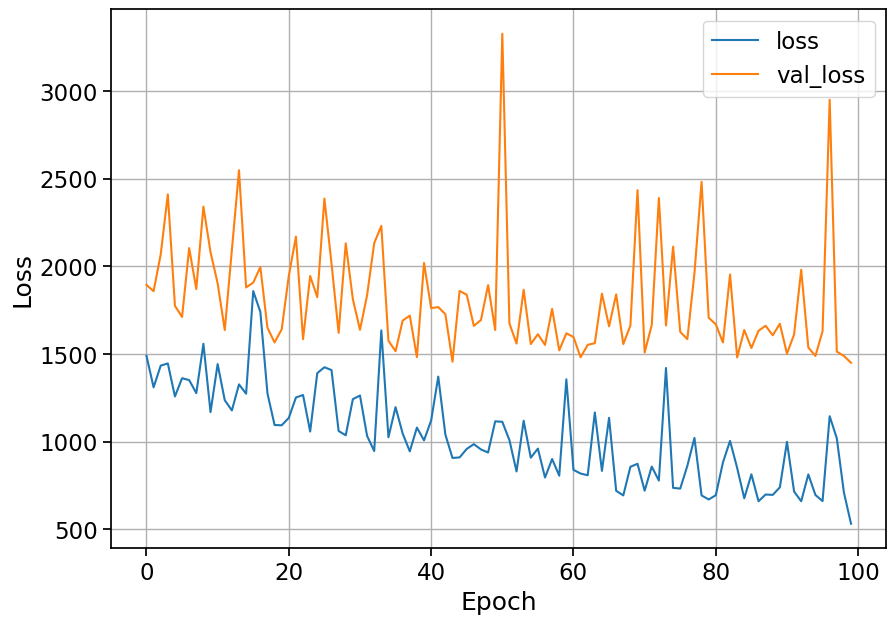

In [45]:
plot_loss()

In [46]:
def plot_mae():
    plt.figure(figsize=(10,7))
    plt.plot(history.history['mae'], label='MAE')
    plt.plot(history.history['val_mae'], label='val_MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)


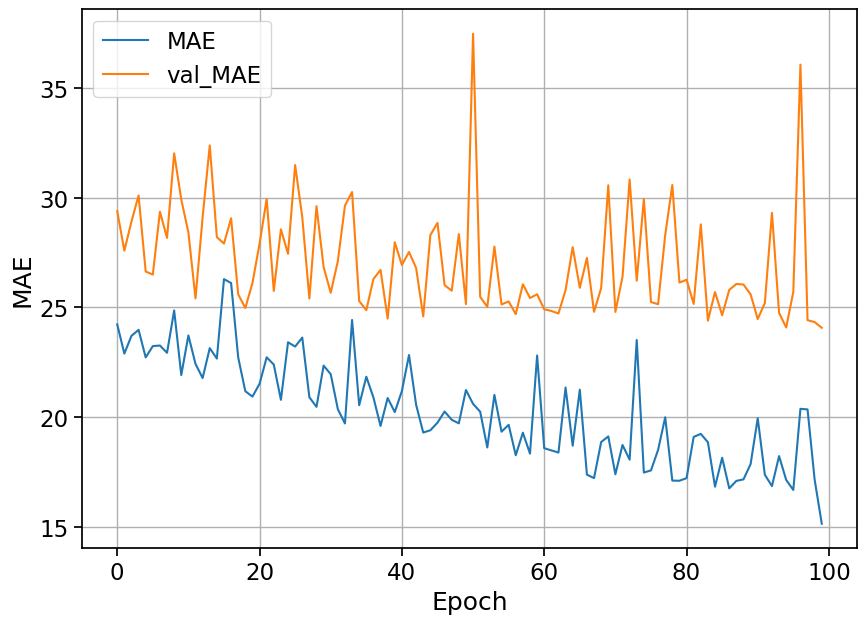

In [47]:
plot_mae()